In [7]:
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# Подход 1: градиентный бустинг "в лоб"

## 1. Считайте таблицу с признаками из файла features.csv

Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [8]:
train = pd.read_csv("data/features.csv", index_col="match_id")
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [9]:
train.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

## 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений.

Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [11]:
count_na = len(train) - train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(train)
print(count_na)

start_time                     0
lobby_type                     0
r1_hero                        0
r1_level                       0
r1_xp                          0
                            ... 
dire_boots_count               0
dire_ward_observer_count       0
dire_ward_sentry_count         0
dire_first_ward_time        1826
radiant_win                    0
Length: 103, dtype: int64


### Обоснование пропусков:
* **first_blood_player2** (второй игрок, причастный к событию) - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.
* **radiant_flying_courier_time** (время приобретения предмета "flying_courier") - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.
* **dire_flying_courier_time** - аналогично **radiant_flying_courier_time**, процент почти тот же (26%).
* **first_blood_time** (игровое время первой крови) - в 20% случаев первой крови нет в первые 5 минут игры.
* **first_blood_team** (команда, совершившая первую кровь) - аналогично **first_blood_time**, процент совпадает (20%).
* **first_blood_player1** (игрок, причастный к событию) - аналогично **first_blood_time**, процент совпадает (20%).
* **dire_bottle_time** (время первого приобретения командой предмета "bottle") - в 16% случаев команда не приобретает предмет "bottle" в первые 5 минут игры.
* **radiant_bottle_time** - аналогично **dire_bottle_time**, процент почти тот же (16%).
* **radiant_first_ward_time** (время установки командой первого "наблюдателя") - очень редкое явление, в 1% случаев команда не ставит "наблюдателя" в первые 5 минут игры.
* **dire_first_ward_time** - аналогично **radiant_first_ward_time**, процент почти тот же (1%).
* **radiant_courier_time** (время приобретения предмета "courier") - самое редкое явление, в 0.5% случаев команда не приобретает предмет "courier" в первые 5 минут игры.
* **dire_courier_time** - аналогично **radiant_courier_time**, процент почти тот же (0.5%).

## 3. Замените пропуски на нули с помощью функции fillna().

На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [12]:
train.fillna(0, inplace=True)

## 4. Какой столбец содержит целевую переменную?

Запишите его название.

In [13]:
X_train = train.drop("radiant_win", axis=1)
y_train = train["radiant_win"]

## 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки".

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
def score_gb(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for n_estimators in [10, 20, 30, 50, 100, 250]:
        print(f"n_estimators={n_estimators}")
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

In [16]:
scores = score_gb(X_train, y_train)
scores.plot()

n_estimators=10
Score: 0.665
Time elapsed: 0:00:12.289551

n_estimators=20
Score: 0.682
Time elapsed: 0:00:22.323785

n_estimators=30
Score: 0.690
Time elapsed: 0:00:31.585027

n_estimators=50


KeyboardInterrupt: 

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:00:45. Показатель метрики качества AUC-ROC в таком случае равен 0.69.

Увеличение количества деревьев также увеличивает показатель метрики AUC-ROC, приближая его к 0.72. Для достижения большего качества имеет смысл использовать более 30 деревьев. Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — например, половину объектов. Также можно уменьшить глубину деревьев (max_depth).

# Подход 2: логистическая регрессия

## 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. 

Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [17]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [18]:
def score_lr(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for i in range(-5, 6):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[i] = score
        print()

    return pd.Series(scores)

C=1e-05
Score: 0.695
Time elapsed: 0:00:02.495872

C=0.0001
Score: 0.711
Time elapsed: 0:00:03.181592

C=0.001
Score: 0.716
Time elapsed: 0:00:04.810646

C=0.01
Score: 0.717
Time elapsed: 0:00:05.816987

C=0.1
Score: 0.717
Time elapsed: 0:00:06.205829

C=1.0
Score: 0.717
Time elapsed: 0:00:06.475861

C=10.0
Score: 0.717
Time elapsed: 0:00:06.482953

C=100.0
Score: 0.717
Time elapsed: 0:00:06.396328

C=1000.0
Score: 0.717
Time elapsed: 0:00:06.392841

C=10000.0
Score: 0.717
Time elapsed: 0:00:06.576441

C=100000.0
Score: 0.717
Time elapsed: 0:00:06.479126



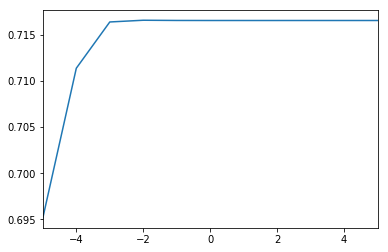

In [12]:
scores = score_lr(X_train, y_train)
scores.plot()

In [19]:
def print_best_lr_score(scores: pd.Series):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = 10.0 ** best_iteration.index[0]
    best_score = best_iteration.values[0]

    print(f"Наилучшее значение показателя AUC-ROC достигается при C = {best_C:.2f} и равно {best_score:.2f}.")

In [14]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


Это сравнимо с градиентным бустингом по 250 деревьям, при этом логистическая регрессия работает заметно быстрее. Отсутствие разницы с градиентным бустингом может говорить о том, что характер связи между данными фичами и целевой переменной - линейный. Тогда такая связь хорошо описывается логистической регрессией и более сложные модели не нужны.

## 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей.

Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [21]:
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
cat_columns = ["lobby_type"] + hero_columns
X_train.drop(cat_columns, axis=1, inplace=True)

KeyError: "['lobby_type' 'r1_hero' 'r2_hero' 'r3_hero' 'r4_hero' 'r5_hero' 'd1_hero'\n 'd2_hero' 'd3_hero' 'd4_hero' 'd5_hero'] not found in axis"

C=1e-05
Score: 0.695
Time elapsed: 0:00:02.120460

C=0.0001
Score: 0.711
Time elapsed: 0:00:01.474868

C=0.001
Score: 0.716
Time elapsed: 0:00:01.635669

C=0.01
Score: 0.717
Time elapsed: 0:00:02.227137

C=0.1
Score: 0.717
Time elapsed: 0:00:02.186818

C=1.0
Score: 0.717
Time elapsed: 0:00:02.225068

C=10.0
Score: 0.717
Time elapsed: 0:00:02.155496

C=100.0
Score: 0.717
Time elapsed: 0:00:02.263729

C=1000.0
Score: 0.717
Time elapsed: 0:00:02.233094

C=10000.0
Score: 0.717
Time elapsed: 0:00:02.179515

C=100000.0
Score: 0.717
Time elapsed: 0:00:02.380262



<AxesSubplot:>

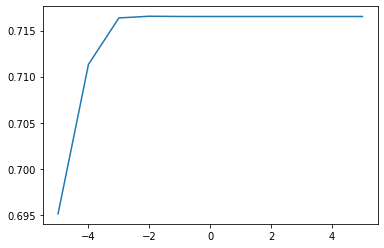

In [22]:
scores = score_lr(X_train, y_train)
scores.plot()

In [17]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


Удаление категориальных признаков не повлияло на качество предсказания. Получается, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.

## 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду.

Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [24]:
unique_heroes = np.unique(train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в train: {len(unique_heroes)}. Максимальный ID героя: {N}.")

Число уникальных героев в train: 108. Максимальный ID героя: 112.


## 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.

Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [25]:
def get_pick(data: pd.DataFrame) -> pd.DataFrame:
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])

X_pick = get_pick(train)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_train = pd.concat([X_train, X_pick], axis=1)

## 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

C=1e-05
Score: 0.699
Time elapsed: 0:00:02.222627

C=0.0001
Score: 0.725
Time elapsed: 0:00:02.316970

C=0.001
Score: 0.746
Time elapsed: 0:00:04.089279

C=0.01
Score: 0.752
Time elapsed: 0:00:07.567037

C=0.1
Score: 0.752
Time elapsed: 0:00:09.151873

C=1.0
Score: 0.752
Time elapsed: 0:00:08.947488

C=10.0
Score: 0.752
Time elapsed: 0:00:08.923319

C=100.0
Score: 0.752
Time elapsed: 0:00:08.865545

C=1000.0
Score: 0.752
Time elapsed: 0:00:08.798281

C=10000.0
Score: 0.752
Time elapsed: 0:00:08.840999

C=100000.0
Score: 0.752
Time elapsed: 0:00:08.924939



<AxesSubplot:>

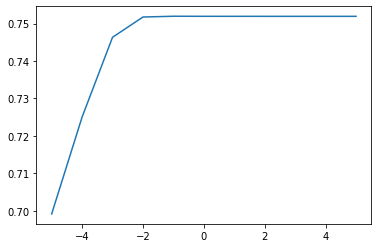

In [27]:
scores = score_lr(X_train, y_train)
scores.plot()

In [22]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.75.


После добавления "мешка слов" по героям качество заметно улучшилось. Это объясняется тем, что вместо отсутствия данных о героях или случайного шума из id мы имеем осмысленную разреженную матрицу для построения предсказания.

## 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации).

Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [28]:
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train, y_train)

/home/nm/Documents/Study/ML/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, random_state=42)

In [29]:
test = pd.read_csv("data/features_test.csv", index_col="match_id")
test.fillna(0, inplace=True)

In [30]:
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
X_test.drop(cat_columns, axis=1, inplace=True)
X_test = pd.concat([X_test, get_pick(test)], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
preds = pd.Series(model.predict_proba(X_test)[:, 1])
preds.describe()

count    17177.000000
mean         0.517031
std          0.220963
min          0.008432
25%          0.346091
50%          0.522135
75%          0.691758
max          0.996372
dtype: float64

<AxesSubplot:ylabel='Frequency'>

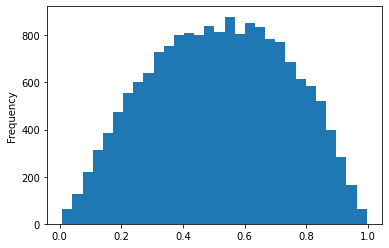

In [32]:
preds.plot.hist(bins=30)